# Comparison of dgemm calls performed within HPL and in a calibration

In [1]:
import io
import os
import zipfile
import pandas
import yaml
import datetime
import re
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning
import json

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df = pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    df['jobid'] = int(get_yaml(archive_name, 'info.yaml')['jobid'])
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
archive = 'dgemm_prediction/5/grenoble_2019-08-22_1879815.zip'

def read_archive(archive_name, exp_id):
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k', 'lda', 'ldb', 'ldc', 'layout', 'transA', 'transB']
    df = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    print('Read trace n°%d from %s: %6d lines' % (exp_id, archive_name, len(df)))
    df['start'] = df.timestamp
    df['end'] = df.timestamp + df.duration
    df = df[['jobid', 'function', 'start', 'end', 'rank', 'm', 'n', 'k', 'lda', 'ldb', 'ldc', 'layout', 'transA', 'transB', 'duration']]
    df['function'] = df['function'].str.strip()
    df['exp_id'] = exp_id
    return df

traces = read_archive(archive, 0)

traces = traces[(traces['function'] == 'dgemm') & (traces['rank'] == 0)].reset_index(drop=True)
traces.m = traces.m.astype(int)
traces.n = traces.n.astype(int)
traces.k = traces.k.astype(int)
print(len(traces))
traces.head()

Read trace n°0 from dgemm_prediction/5/grenoble_2019-08-22_1879815.zip: 241384 lines
7560


,jobid,function,start,end,rank,m,n,k,lda,ldb,ldc,layout,transA,transB,duration,exp_id
0,1879815,dgemm,0.000815,0.000858,0,7678,2,2,NaN,NaN,NaN,NaN,NaN,NaN,0.000043,0
1,1879815,dgemm,0.001048,0.001110,0,7676,4,4,NaN,NaN,NaN,NaN,NaN,NaN,0.000063,0
2,1879815,dgemm,0.001268,0.001293,0,7674,2,2,NaN,NaN,NaN,NaN,NaN,NaN,0.000025,0
3,1879815,dgemm,0.001452,0.001593,0,7672,8,8,NaN,NaN,NaN,NaN,NaN,NaN,0.000141,0
4,1879815,dgemm,0.001749,0.001775,0,7670,2,2,NaN,NaN,NaN,NaN,NaN,NaN,0.000026,0


For the record, the different numerical values for the arguments of dgemm are (according to my tests):
```
CblasColMajor: 102
CblasRowMajor: 101
CblasNoTrans : 111
CblasTrans   : 112
```

In [3]:
calibration_archive = 'dgemm_prediction/5/grenoble_2019-08-22_1879819.zip'
traces_calibration = read_csv(calibration_archive, 'result.csv')
print(list(sorted(traces_calibration['core'].unique())))
print(len(list(traces_calibration['core'].unique())))
traces_calibration = traces_calibration[traces_calibration['core'] == 2]
traces_calibration = traces_calibration.reset_index(drop=True)
print(len(traces_calibration))
traces_calibration.head()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
32
7560


,function,m,n,k,timestamp,duration,core,jobid
0,dgemm,7678,2,2,152.072850,0.000036,2,1879819
1,dgemm,7676,4,4,152.072910,0.000069,2,1879819
2,dgemm,7674,2,2,152.072982,0.000024,2,1879819
3,dgemm,7672,8,8,152.073009,0.000124,2,1879819
4,dgemm,7670,2,2,152.073135,0.000025,2,1879819


In [4]:
sizelist_hpl = [list(t[1]) for t in traces[['m', 'n', 'k']].iterrows()]
sizelist_cal = [list(t[1]) for t in traces_calibration[['m', 'n', 'k']].iterrows()]
assert sizelist_hpl == sizelist_cal

In [5]:
traces['duration_calibration'] = traces_calibration['duration']
traces['mnk'] = traces.m * traces.n * traces.k

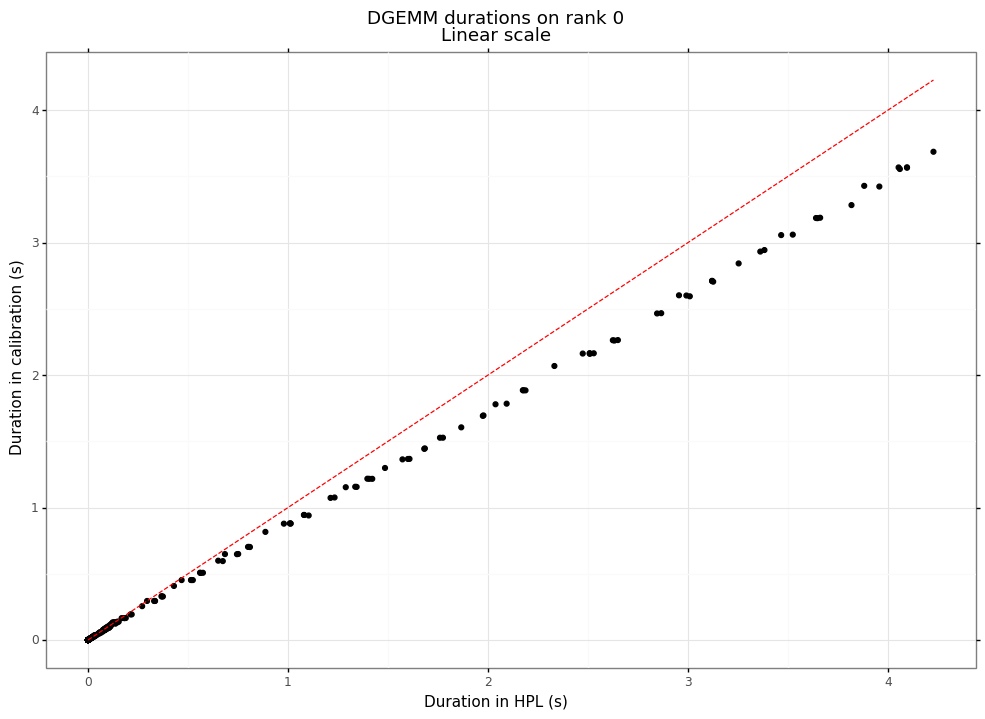

<ggplot: (8747380683503)>


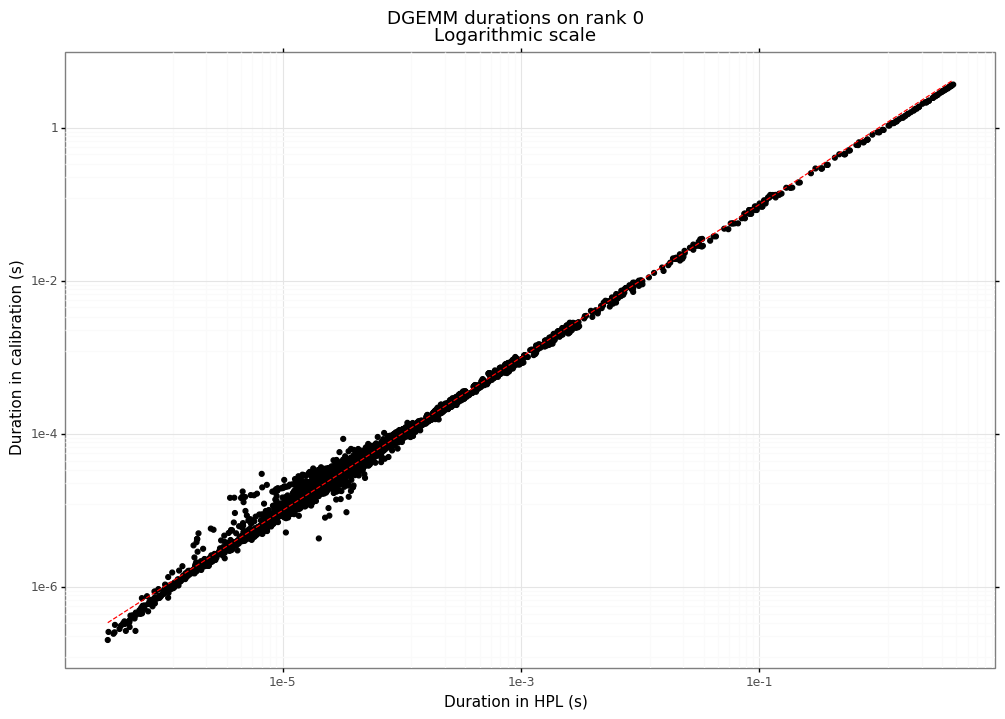

<ggplot: (-9223363289474141710)>


In [6]:
plot = ggplot(traces, aes(x='duration', y='duration_calibration')) + theme_bw() + geom_point() + geom_line(aes(x='duration', y='duration'), color='red', linetype='dashed')
plot = plot + xlab('Duration in HPL (s)') + ylab('Duration in calibration (s)')
title = 'DGEMM durations on rank 0\n'
print(plot + ggtitle(title + 'Linear scale'))
print(plot + scale_x_log10() + scale_y_log10() + ggtitle(title + 'Logarithmic scale'))

In [7]:
traces['gflops_hpl'] = 2*traces.mnk / traces['duration'] * 1e-9
traces['gflops_calibration'] = 2*traces.mnk / traces['duration_calibration'] * 1e-9

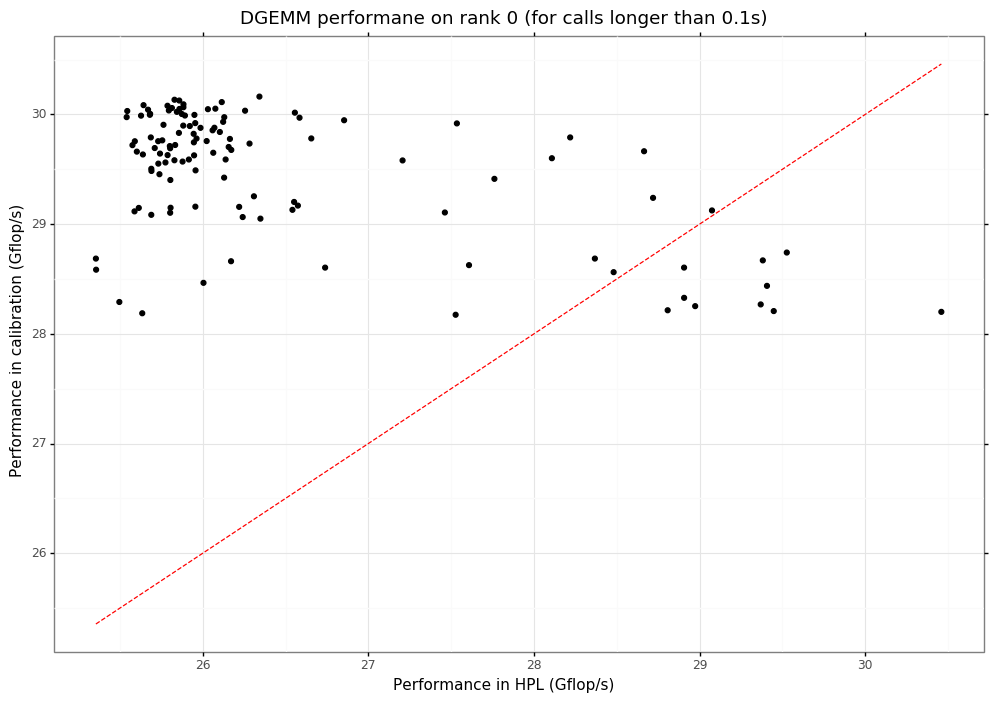

<ggplot: (-9223363289478659342)>

In [8]:
plot = ggplot(traces[traces.duration > 0.1], aes(x='gflops_hpl', y='gflops_calibration')) + theme_bw() + geom_point() + geom_line(aes(x='gflops_hpl', y='gflops_hpl'), color='red', linetype='dashed')
plot = plot + xlab('Performance in HPL (Gflop/s)') + ylab('Performance in calibration (Gflop/s)')
plot + ggtitle('DGEMM performane on rank 0 (for calls longer than 0.1s)')

In [9]:
summary = traces[['duration', 'duration_calibration', 'mnk']].sum()
summary['gflops'] = 2*summary['mnk'] / summary['duration'] * 1e-9
summary['gflops_calibration'] = 2*summary['mnk'] / summary['duration_calibration'] * 1e-9
summary['error'] = (summary['duration_calibration'] - summary['duration']) / summary['duration']
summary

duration                1.735122e+02
duration_calibration    1.517849e+02
mnk                     2.250607e+12
gflops                  2.594177e+01
gflops_calibration      2.965521e+01
error                  -1.252204e-01
dtype: float64

## Monitoring

In [10]:
def get_monitoring(archive_name, csv_name, tag):
    df = read_csv(archive_name, csv_name)
    for col in ['start', 'stop']:
        df[col] = pandas.to_datetime(df[col])
    first = df['start'].min()
    df['start'] -= first
    df['stop'] -= first
    df['tag'] = tag
    return df

In [11]:
temperature = pandas.concat([
    get_monitoring(archive, 'monitoring_temp.csv', tag='HPL'),
    get_monitoring(calibration_archive, 'monitoring_temp.csv', tag='calibration')
])
temperature.head()

,hostname,start,stop,sensor_id,temperature,jobid,tag
0,dahu-2.grenoble.grid5000.fr,00:00:00,00:00:00.000188,0,65.0,1879815,HPL
1,dahu-2.grenoble.grid5000.fr,00:00:00,00:00:00.000188,1,61.0,1879815,HPL
2,dahu-2.grenoble.grid5000.fr,00:00:01.002878,00:00:01.003258,0,74.0,1879815,HPL
3,dahu-2.grenoble.grid5000.fr,00:00:01.002878,00:00:01.003258,1,62.0,1879815,HPL
4,dahu-2.grenoble.grid5000.fr,00:00:02.006078,00:00:02.006304,0,76.0,1879815,HPL


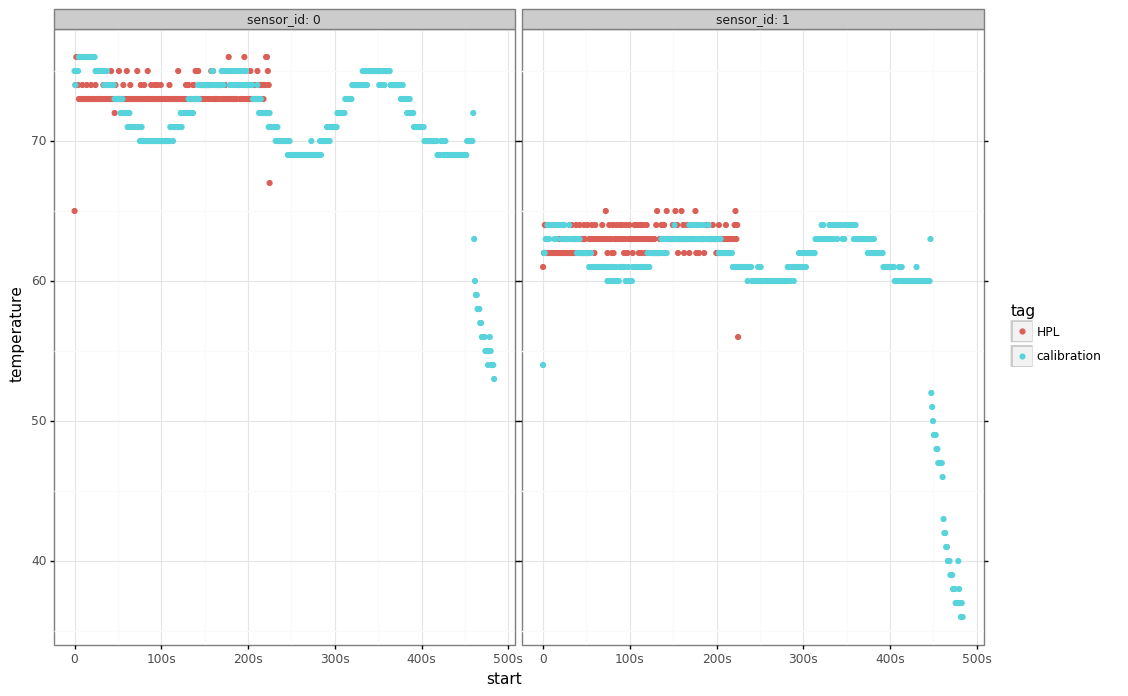

<ggplot: (-9223363289478639016)>

In [12]:
ggplot(temperature, aes(x='start', y='temperature', color='tag')) + geom_point() + theme_bw() +  facet_wrap('sensor_id', labeller='label_both')

In [13]:
frequency = pandas.concat([
    get_monitoring(archive, 'monitoring_freq.csv', tag='HPL'),
    get_monitoring(calibration_archive, 'monitoring_freq.csv', tag='calibration')
])
frequency.head()

,hostname,start,stop,core_id,frequency,jobid,tag
0,dahu-2.grenoble.grid5000.fr,0 days,00:00:00.001478,0,1960675000,1879815,HPL
1,dahu-2.grenoble.grid5000.fr,0 days,00:00:00.001478,1,3450439000,1879815,HPL
2,dahu-2.grenoble.grid5000.fr,0 days,00:00:00.001478,2,999884000,1879815,HPL
3,dahu-2.grenoble.grid5000.fr,0 days,00:00:00.001478,3,1386968000,1879815,HPL
4,dahu-2.grenoble.grid5000.fr,0 days,00:00:00.001478,4,2575268000,1879815,HPL


In [14]:
frequency['cpu_id'] = frequency['core_id'] % 2
frequency = frequency[frequency['core_id'] < 32]  # removing the hyperthread cores

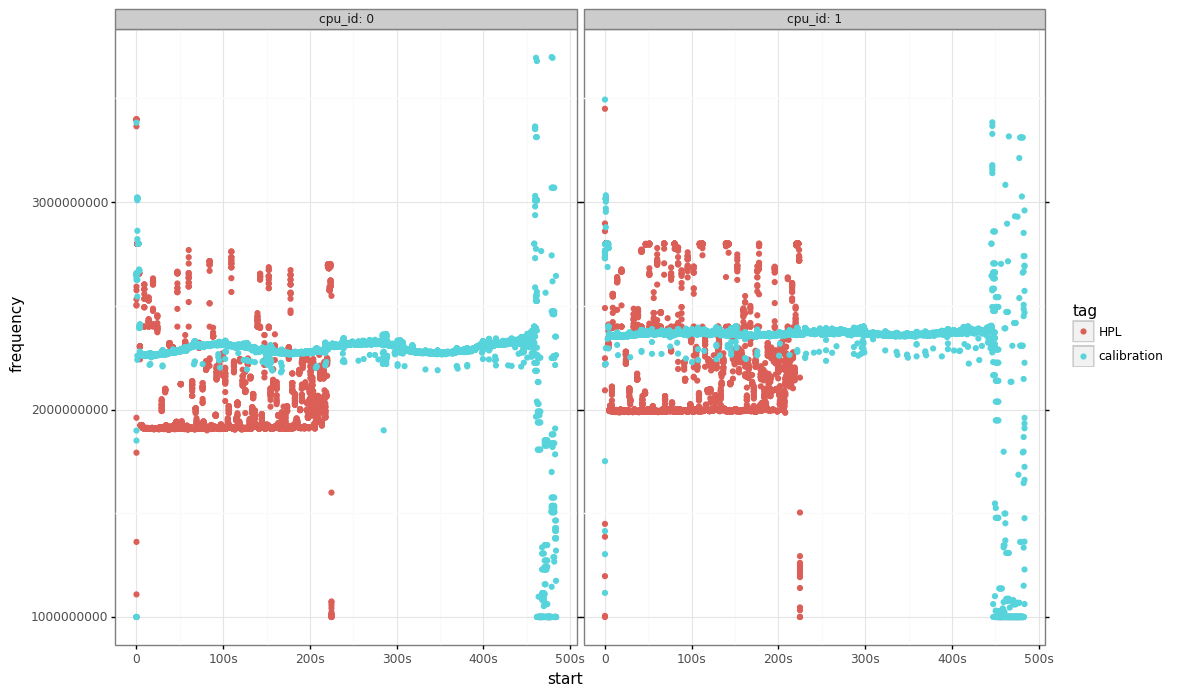

<ggplot: (8747375461117)>

In [15]:
ggplot(frequency, aes(x='start', y='frequency', color='tag')) + geom_point() + theme_bw() +  facet_wrap('cpu_id', labeller='label_both')

In [16]:
tmp_freq = frequency[(frequency['start'] > pandas.to_timedelta(10, unit='s')) & (frequency['start'] < pandas.to_timedelta(200, unit='s'))]

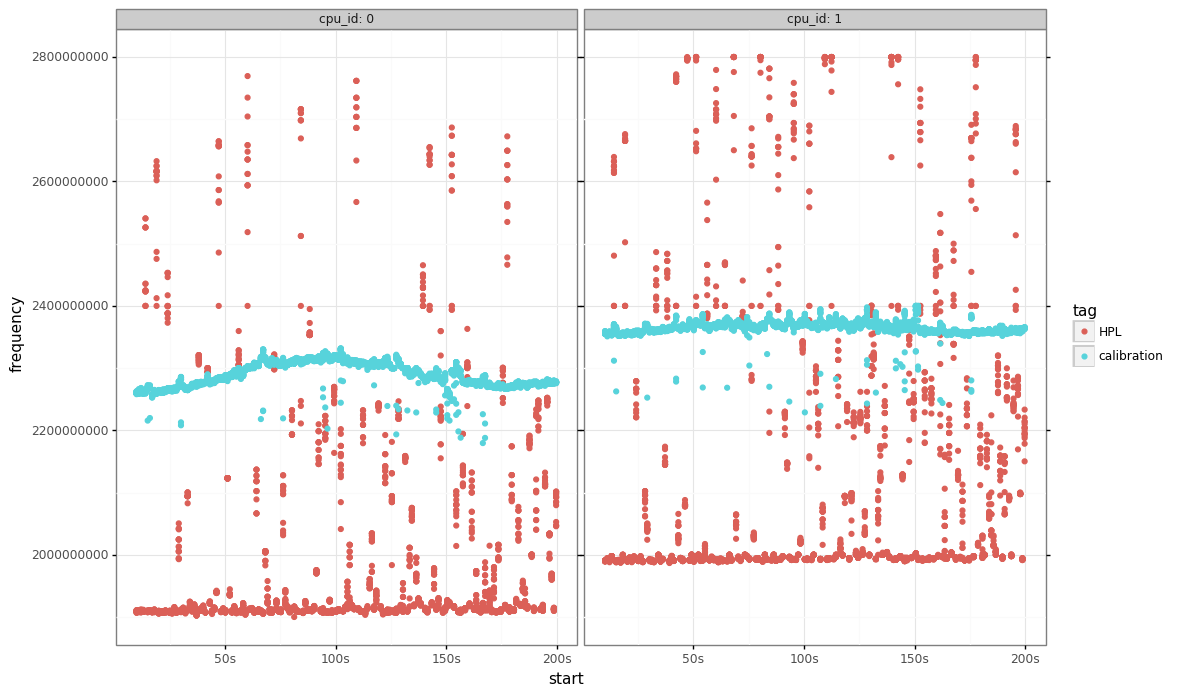

<ggplot: (-9223363289482770288)>

In [17]:
ggplot(tmp_freq, aes(x='start', y='frequency', color='tag')) + geom_point() + theme_bw() +  facet_wrap('cpu_id', labeller='label_both')

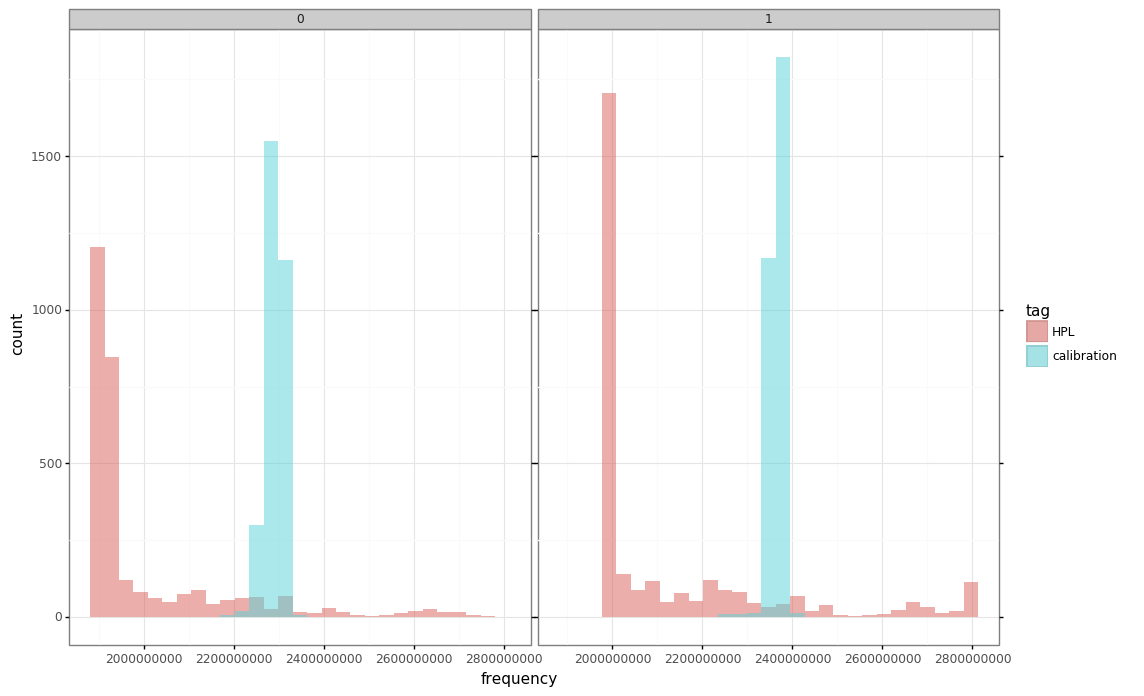

<ggplot: (-9223363289496076463)>

In [18]:
ggplot(tmp_freq, aes(x='frequency', fill='tag')) + geom_histogram(alpha=0.5, position='identity') + facet_wrap(['cpu_id']) + theme_bw()

In [19]:
tmp_freq.groupby(['cpu_id', 'tag'])['frequency'].describe()

count          mean           std           min  \
cpu_id tag                                                             
0      HPL          3040.0  2.006358e+09  1.772917e+08  1.899920e+09   
       calibration  3040.0  2.288904e+09  1.979480e+07  2.179467e+09   
1      HPL          3040.0  2.132990e+09  2.255446e+08  1.986694e+09   
       calibration  3040.0  2.364758e+09  1.242138e+07  2.228814e+09   

                             25%           50%           75%           max  
cpu_id tag                                                                  
0      HPL          1.909918e+09  1.915750e+09  2.024505e+09  2.769323e+09  
       calibration  2.273675e+09  2.286300e+09  2.307641e+09  2.331610e+09  
1      HPL          1.993103e+09  1.999896e+09  2.216286e+09  2.799957e+09  
       calibration  2.359295e+09  2.364807e+09  2.370062e+09  2.399926e+09

In [20]:
mean_hpl = tmp_freq[tmp_freq.tag == 'HPL'].frequency.mean()
mean_cal = tmp_freq[tmp_freq.tag == 'calibration'].frequency.mean()
(mean_cal - mean_hpl) / mean_hpl

0.12424973000601007

## Trace of the commands

In [21]:
def print_commands(archive):
    print(zipfile.ZipFile(archive).read('commands.log').decode())

print_commands(archive)

[2019-08-22 14:52:05,074][INFO] Starting a new job, args = {'expfile': [ExpFile(exp.csv)], 'command': 'run', 'installfile': InstallFile(install.yaml), 'jobid': ('grenoble', 1879815), 'batch': False, 'username': 'tocornebize', 'deploy': 'debian9-x64-base'}
[2019-08-22 14:52:05,086][DEBUG] [frontend | /home/tocornebize] oarstat -fJ -j 1879815
[2019-08-22 14:52:06,203][INFO] HPL(1879815) with 1 nodes
[2019-08-22 14:52:06,203][INFO] Setting up
[2019-08-22 14:52:06,203][DEBUG] [frontend | /home/tocornebize] kadeploy3 -k -f /var/lib/oar/1879815 -e debian9-x64-base --env-version 2019040916
[2019-08-22 14:56:48,378][DEBUG] [allnodes | /tmp] echo "hello world"
[2019-08-22 14:56:48,603][DEBUG] [allnodes | /tmp] cat /sys/class/thermal/thermal_zone*/temp
[2019-08-22 14:56:48,656][DEBUG] [allnodes | /tmp] rm -rf /tmp/*
[2019-08-22 14:56:48,704][DEBUG] [director | /tmp] echo UEsFBgAAAAAAAAAAAAAAAAAAAAAAAA== | base64 -d > grenoble_2019-08-22_1879815.zip
[2019-08-22 14:56:48,752][DEBUG] [director | /r

In [22]:
print_commands(calibration_archive)

[2019-08-22 15:16:45,708][INFO] Starting a new job, args = {'username': 'tocornebize', 'command': 'run', 'batch': False, 'jobid': ('grenoble', 1879819), 'deploy': 'debian9-x64-base', 'installfile': InstallFile(install.yaml), 'expfile': [ExpFile(exp_hpl.csv)]}
[2019-08-22 15:16:45,717][DEBUG] [frontend | /home/tocornebize] oarstat -fJ -j 1879819
[2019-08-22 15:16:46,391][INFO] BLASCalibration(1879819) with 1 nodes
[2019-08-22 15:16:46,392][INFO] Setting up
[2019-08-22 15:16:46,392][DEBUG] [frontend | /home/tocornebize] kadeploy3 -k -f /var/lib/oar/1879819 -e debian9-x64-base --env-version 2019040916
[2019-08-22 15:21:29,991][DEBUG] [allnodes | /tmp] echo "hello world"
[2019-08-22 15:21:30,220][DEBUG] [allnodes | /tmp] cat /sys/class/thermal/thermal_zone*/temp
[2019-08-22 15:21:30,267][DEBUG] [allnodes | /tmp] rm -rf /tmp/*
[2019-08-22 15:21:30,315][DEBUG] [director | /tmp] echo UEsFBgAAAAAAAAAAAAAAAAAAAAAAAA== | base64 -d > grenoble_2019-08-22_1879819.zip
[2019-08-22 15:21:30,363][DEBUG